In [ ]:
# Reading the 'Nat_Gas.csv' file using pandas
import pandas as pd
data = pd.read_csv('Nat_Gas.csv')

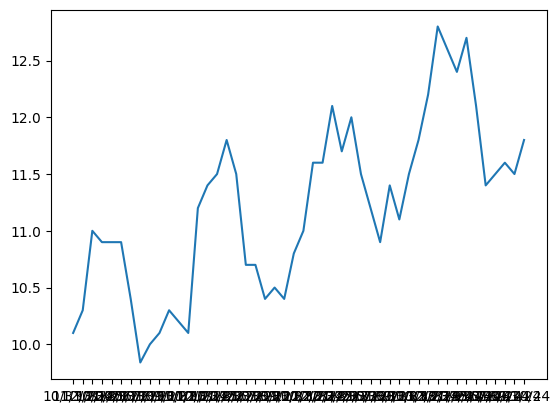

In [ ]:
# Plotting the data to get an understanding of the price behavior
import matplotlib.pyplot as plt
plt.plot(data['Dates'], data['Prices'])

In [3]:
# Idea is to use SARIMA (seasonal autoregressive integrated moving average) to model the natural gas prices

data['Dates'] = pd.to_datetime(data['Dates'], format='%m/%d/%y')
data.set_index('Dates', inplace=True)
data = data.asfreq('M')  # Set the frequency to monthly - tells the model that the data is monthly

C:\Users\darsh\AppData\Local\Temp\ipykernel_20968\133158280.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.asfreq('M')  # Set the frequency to monthly - tells the model that the data is monthly


In [5]:
'''Use SARIMA(p,d,q)(P,D,Q,s), where:
p, d, q = ARIMA terms (trend)
P, D, Q, s = seasonal terms
s = 12 (for yearly seasonality)'''

from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA model: using (1,1,1)(1,1,1,12) as a starting point
model = SARIMAX(data['Prices'], order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit(disp=False)

c:\Users\darsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\darsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [6]:
# forecasting the next 12 months
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int() # confidence intervals - upper and lower bounds of the forecast and is set to 95% by default

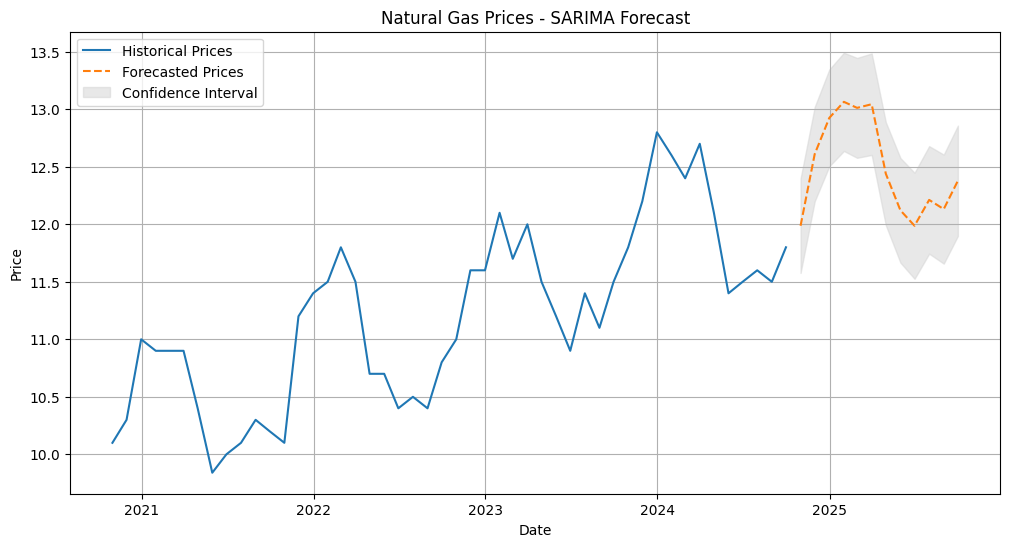

In [7]:
# plot historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Prices'], label='Historical Prices')
plt.plot(predicted_mean.index, predicted_mean, label='Forecasted Prices', linestyle='--')
plt.fill_between(predicted_mean.index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='lightgray', alpha=0.5, label='Confidence Interval')
plt.title('Natural Gas Prices - SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# function to get the forecasted prices
def estimate_price(date_str):
    target_date = pd.to_datetime(date_str)
    last_date = data.index[-1]
    
    if target_date <= last_date:
        return data.loc[target_date, 'Prices']
    
    # Forecast only if needed
    months_ahead = (target_date.year - last_date.year) * 12 + (target_date.month - last_date.month)
    forecast = results.get_forecast(steps=months_ahead)
    pred_mean = forecast.predicted_mean
    return float(pred_mean[-1].round(2))

In [14]:
estimate_price('12/31/2024')  # Example usage to estimate price for a future date

C:\Users\darsh\AppData\Local\Temp\ipykernel_20968\1748908232.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return float(pred_mean[-1].round(2))


12.93

In [31]:
# Good start so far. Now I want to create a function that will allow me to estimate the price of natural gas for any date from the current set as well, not just the next 12 months.

def estimate_price(date_str):
    """
    Estimate the gas price for any given date (past or future).
    - Uses actual value if available
    - Interpolates for past dates
    - Forecasts with SARIMA for future dates
    """
    target_date = pd.to_datetime(date_str)
    first_known_date = data.index.min()
    last_known_date = data.index.max()

    # Reindex full known data to daily
    daily_index = pd.date_range(start=first_known_date, end=last_known_date, freq='D')
    daily_prices = data['Prices'].reindex(daily_index)
    interpolated_prices = daily_prices.interpolate('time')

    # 1. If the date is within historical data, return interpolated value
    if target_date <= last_known_date:
        return float(interpolated_prices.loc[target_date].round(2))

    # 2. Else forecast forward using SARIMA
    months_ahead = (target_date.year - last_known_date.year) * 12 + (target_date.month - last_known_date.month)
    forecast = results.get_forecast(steps=months_ahead)
    forecast_mean = forecast.predicted_mean

    # Create monthly forecast index
    forecast_index = pd.date_range(start=last_known_date + pd.offsets.MonthEnd(), periods=months_ahead, freq='M')
    forecast_series = pd.Series(forecast_mean.values, index=forecast_index)

    # Reindex forecast to daily, interpolate, then get the target
    full_forecast_index = pd.date_range(start=forecast_index[0], end=forecast_index[-1], freq='D')
    daily_forecast = forecast_series.reindex(full_forecast_index)
    interpolated_forecast = daily_forecast.interpolate('time')

    return float(interpolated_forecast.loc[target_date].round(2))


In [32]:
estimate_price('12/31/2024')  # Example usage to estimate price for a future date

C:\Users\darsh\AppData\Local\Temp\ipykernel_20968\993426100.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_known_date + pd.offsets.MonthEnd(), periods=months_ahead, freq='M')


12.93

In [33]:
estimate_price('12/31/2023')  # Example usage to estimate price for a date in the past that is in the dataset

12.8

In [34]:
estimate_price('12/29/2023')  # Example usage to estimate price for a date in the past that is not in the dataset

12.76